In [20]:
# display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

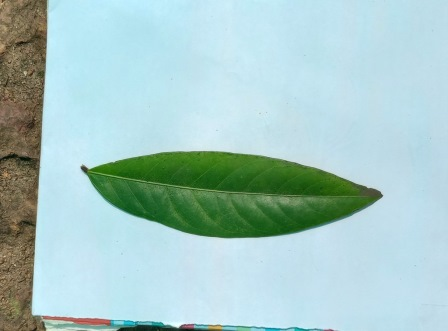

In [24]:
# daisy
img_daisy = image.load_img("./compdata/Asoca\\Asoca001.jpg")
img_daisy

In [25]:
splitfolders.ratio("./compdata", output="./split_data", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)


Copying files: 500 files [00:01, 342.39 files/s]


In [26]:
datagen = ImageDataGenerator()

In [27]:
# define classes name
class_names = ['Asoca','Changalamparanda','Illipa','Nannari','Thipalli']

In [28]:
# training data
train_generator = datagen.flow_from_directory( 
    directory="./split_data/train/", 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="binary", 
)

Found 350 images belonging to 5 classes.


In [29]:
# validation data
valid_generator = datagen.flow_from_directory( 
    directory="./split_data/val/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 100 images belonging to 5 classes.


In [30]:
# test data
test_generator = datagen.flow_from_directory( 
    directory="./split_data/test/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 50 images belonging to 5 classes.


In [31]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [32]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [33]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [34]:
# launch the training
model_history = trainModel(model = model, epochs = 10, optimizer = "Adam")

Epoch 1/10

11/11 [==============================] - 72s 6s/step - loss: 2.4624 - accuracy: 0.2114 - val_loss: 1.5310 - val_accuracy: 0.2700
Epoch 2/10
11/11 [==============================] - 52s 5s/step - loss: 1.9704 - accuracy: 0.2429 - val_loss: 1.4239 - val_accuracy: 0.6700
Epoch 3/10
11/11 [==============================] - 54s 5s/step - loss: 1.6342 - accuracy: 0.2943 - val_loss: 1.2858 - val_accuracy: 0.8600
Epoch 4/10
11/11 [==============================] - 53s 5s/step - loss: 1.5219 - accuracy: 0.3257 - val_loss: 1.2154 - val_accuracy: 0.8000
Epoch 5/10
11/11 [==============================] - 55s 5s/step - loss: 1.3207 - accuracy: 0.4286 - val_loss: 1.0275 - val_accuracy: 0.8900
Epoch 6/10
11/11 [==============================] - 54s 5s/step - loss: 1.2532 - accuracy: 0.4771 - val_loss: 0.8019 - val_accuracy: 0.9400
Epoch 7/10
11/11 [==============================] - 53s 5s/step - loss: 1.0441 - accuracy: 0.5914 - val_loss: 0.5822 - val_accuracy: 0.9400
Epoch 8/10
11/11 [=

In [35]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

2/2 [==============================] - 6s 2s/step - loss: 0.1593 - accuracy: 0.9800
The test loss is:  0.15934431552886963
The best accuracy is:  98.00000190734863


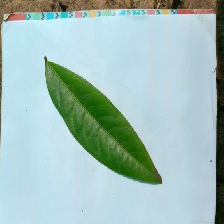

In [85]:
img = tf.keras.preprocessing.image.load_img('./Asoca023.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [86]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 244ms/step
[[0.94025666 0.03256769 0.00508147 0.00213219 0.01996197]]


In [87]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[0]


In [88]:
# transform classes number into classes name
class_names[class_id.item()]

'Asoca'

In [90]:
import scipy
predictions = predictions.flatten()
# cal. z score
z = scipy.stats.zscore(predictions)
prob_value = scipy.special.softmax(z)
prob_value

array([0.75251484, 0.0648532 , 0.06021354, 0.05973585, 0.06268257],
      dtype=float32)

In [91]:
# top two probabilty values
top_2_prob_ind = prob_value.argsort()[::-1][:3]
top_2_prob_ind

array([0, 1, 4], dtype=int64)

In [92]:
# for making pipeline clasnames should be defined in array
top_labels = [class_names[class_id.item()] for class_id in top_2_prob_ind]
top_prob = prob_value[top_2_prob_ind]

In [93]:
top_prob,top_labels

(array([0.75251484, 0.0648532 , 0.06268257], dtype=float32),
 ['Asoca', 'Changalamparanda', 'Thipalli'])

In [94]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [95]:
top_dict


{'Asoca': 0.753, 'Changalamparanda': 0.065, 'Thipalli': 0.063}

In [106]:

# MODELING A PIPELINE
def pipeline_model(path,model):
    # pipeline model
    # have already loaded the image
    image = skimage.io.imread(path)
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    # RESIZE AND PROCESS IMAGE
    # image_resize = skimage.transform.resize(image,(224, 224))
    # CONVERTING IMAGE INTO ARRAY
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.array([img_array])
    # generate predictions for samples
    predictions = model.predict(img_array)
    # define classes name
    class_names = ['Asoca','Changalamparanda','Illipa','Nannari','Thipalli']
    # generate argmax for predictions
    class_id = np.argmax(predictions, axis = 1)
    predictions = predictions.flatten()
    # cal. z score
    z = scipy.stats.zscore(predictions)
    prob_value = scipy.special.softmax(z)
    # getting top three probabilty values
    top_2_prob_ind = prob_value.argsort()[::-1][:3]
    # for making pipeline clasnames should be defined in array
    top_labels = [class_names[class_id.item()] for class_id in top_2_prob_ind]
    top_prob = prob_value[top_2_prob_ind]
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    return top_dict
    
    
    
   

In [108]:
res = pipeline_model('Thipalli001.jpg',model)
res

1/1 [==============================] - 0s 352ms/step


{'Thipalli': 0.753, 'Asoca': 0.064, 'Nannari': 0.061}

In [101]:
import warnings
from keras.models import load_model
from keras.applications.resnet50 import ResNet50

# Save the model in HDF5 format and suppress the warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model.save('resnet50_new.h5')